In [1]:
# this is the pipeline of Anti analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import copy
import numpy as np
import tree_util
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection as fdr
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib as mpl 
mpl.rcParams['pdf.fonttype'] = 42
import warnings 
warnings.filterwarnings('ignore')
def format_func(value, tick_number):
    return f"{value:.2e}"

In [2]:
def ex_df(d_df, profile, sname):
    sp_list = list(set(profile.columns).intersection(set(d_df.index)))
    sp_d_df = d_df.loc[sp_list, sp_list]
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    
    cor_df = sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    ex_df = pd.DataFrame(value, index=sp_list, columns=sp_list)
    return ex_df

def exchange_v(ex_df, node_leaves):
    result_dict = {}
    for node, leaves in node_leaves.items():
        leaves = list(set(leaves).intersection(set(ex_df.index)))
        if len(leaves) == 0:
            result_dict[node] = 0
            continue
        tmp = ex_df.loc[leaves, leaves]
        result_dict[node] = tmp.sum().sum()/2
    return result_dict

def multisample_ev(profile, d_df, node_leaves):
    result = pd.DataFrame(index=profile.index, columns=(list(node_leaves.keys())))
    for sname in profile.index:
        edge_df = ex_df(d_df, profile, sname)
        tmp = exchange_v(edge_df, node_leaves)
        for node in tmp.keys():
            value = tmp[node]
            result.loc[sname, node] = value
    return result

In [3]:
def main(pheno_profiles, sp_d, node_leaves):
    for pheno, profile in pheno_profiles.items():
        profile = profile.T
        profile = profile.rename(columns=lambda x: x.replace('_', '-'))
        profile = profile.rename(columns=lambda x: x.replace(' ', '-'))
        pheno_profiles[pheno] = profile
    ev_result = {}   
    for p, profile in pheno_profiles.items():
        p_result = multisample_ev(profile, sp_d, node_leaves)
        ev_result[p] = copy.deepcopy(p_result)
    return ev_result

In [4]:
d_df = pd.read_csv('../result/S1_plasmid_net/tree/log_rescale.tsv', sep='\t', header=0, index_col=0)
#d_df = pd.read_csv('../result/plasmid_net/feature/degree_norm.tsv', sep='\t', header=0, index_col=0)

with open('../result/S1_plasmid_net/tree/log_rescale/gksb/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()

json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
renamed_d = d_df.rename(columns=name_dict, index=name_dict)
renamed_d = renamed_d.loc[leaf_list, leaf_list]
result = {}
# compute leaf layer
result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

result['leaves_dict']['root'] = {'root': list(name_dict.values())}
node_leaves['root'] = list(name_dict.values())

In [5]:
tlevel = 'g'
idir = '../data/anti/Anti'
outdir = '../result/S4_Anti/Anti1'
if not os.path.exists(outdir):
    os.makedirs(outdir)
metadata_path = os.path.join(idir, 'metadata_new.tsv')
metadata = pd.read_csv(metadata_path, sep='\t', header=0, index_col=0)
abd = pd.read_csv(os.path.join(idir, 'ERP009131_{}.tsv'.format(tlevel)), header=0, index_col=0, sep='\t')

# exposed group
exposed_metadata = metadata[metadata['type']=='Exposed']
days = [0, 7, 90]
tmpl = '{}E{}'
samples = set()
for s in exposed_metadata.index:
    s = s.split('E')[0]
    samples.add(s)
exposed_day_data_dict = {}
for d in days:
    day_dict = {}
    for s in samples:
        idx = tmpl.format(s, d)
        day_dict[idx] = s
    exposed_day_data_dict[d] = copy.deepcopy(abd[list(day_dict.keys())])
    exposed_day_data_dict[d] = exposed_day_data_dict[d].rename(columns=day_dict)       

exposed_ev_dict = main(exposed_day_data_dict, renamed_d, node_leaves)
for d in exposed_ev_dict.keys():
    exposed_ev_dict[d].to_csv(os.path.join(outdir, 'exposed_TI_{}.tsv'.format(d)), sep='\t')

In [6]:

# control group
control_metadata = metadata[metadata['type']=='Control']
days = [0, 7, 90]
tmpl = '{}C{}'
samples = set()
for s in control_metadata.index:
    s = s.split('C')[0]
    samples.add(s)
control_day_data_dict = {}
for d in days:
    day_dict = {}
    for s in samples:
        idx = tmpl.format(s, d)
        day_dict[idx] = s
    control_day_data_dict[d] = copy.deepcopy(abd[list(day_dict.keys())])
    control_day_data_dict[d] = control_day_data_dict[d].rename(columns=day_dict)

control_ev_dict = main(control_day_data_dict, renamed_d, node_leaves)
for d in control_ev_dict.keys():
    control_ev_dict[d].to_csv(os.path.join(outdir, 'control_TI_{}.tsv'.format(d)), sep='\t')


In [7]:
def compare(pheno_profiles, p_cutoff, case_label, control_label):
    p_df = pd.DataFrame(columns=['p', 'mean({})'.format(case_label), 'mean({})'.format(control_label), 'var({})'.format(case_label), 'var({})'.format(control_label), 'fc({}/{})'.format(case_label, control_label), 'diff({}-{})'.format(case_label, control_label), 'abs', 'non_zero({})'.format(control_label), 'non_zero({})'.format(case_label), 'non_zero%({})'.format(control_label), 'non_zero%({})'.format(case_label)], index=list(pheno_profiles[case_label].columns))

    # check each cluster
    valid_clusters = []
    for sp in pheno_profiles[case_label].columns:
        disease_v = list(pheno_profiles[case_label][sp])
        control_v = list(pheno_profiles[control_label][sp])
        p_df.loc[sp, 'mean({})'.format(case_label)] = np.mean(disease_v)
        p_df.loc[sp, 'mean({})'.format(control_label)] = np.mean(control_v)
        p_df.loc[sp, 'var({})'.format(case_label)] = np.var(disease_v)
        p_df.loc[sp, 'var({})'.format(control_label)] = np.var(control_v)

        p_df.loc[sp, 'diff({}-{})'.format(case_label, control_label)] = p_df.loc[sp, 'mean({})'.format(case_label)] - p_df.loc[sp, 'mean({})'.format(control_label)]
        p_df.loc[sp, 'fc({}/{})'.format(case_label, control_label)] = p_df.loc[sp, 'mean({})'.format(case_label)]/p_df.loc[sp, 'mean({})'.format(control_label)]
        p_df.loc[sp,'non_zero({})'.format(case_label)] = len(disease_v) - disease_v.count(0)
        p_df.loc[sp, 'non_zero({})'.format(control_label)] = len(control_v) - control_v.count(0)
        p_df.loc[sp, 'non_zero%({})'.format(case_label)] = p_df.loc[sp, 'non_zero({})'.format(case_label)]/len(disease_v)
        p_df.loc[sp, 'non_zero%({})'.format(control_label)] = p_df.loc[sp, 'non_zero({})'.format(control_label)]/len(control_v)
        if (list(disease_v).count(0) > len(list(disease_v))*0.8) and (list(control_v).count(0) > len(list(control_v))*0.8):
            continue
        valid_clusters.append(sp)
        t, p = mannwhitneyu(disease_v, control_v)
        #print(len(disease_v), len(control_v), len(disease_v) + len(control_v))
        p_df.loc[sp, 'p'] = p
    p_adj = fdr(list(p_df.loc[valid_clusters, 'p']), p_cutoff)[1]
    for i, sp in enumerate(valid_clusters):
        p_df.loc[sp, 'p_adj'] = p_adj[i]
    p_df['abs'] = abs(p_df['diff({}-{})'.format(case_label, control_label)])
    return p_df

def check(p_df, p_cutoff):
    p_df.dropna(inplace=True)
    valid_clusters = []
    for idx in p_df.index:
        for c in p_df.columns:
            if not np.isnan(p_df.loc[idx, c]):
                if p_df.loc[idx, c] < p_cutoff:
                    valid_clusters.append(idx)
                    break
    return valid_clusters

def show_valid(df):
    df.fillna(np.nan, inplace=True)
    valid_clusters = check(df, 0.05)
    plot_p = df.loc[valid_clusters, ]
    return plot_p

In [8]:
ec_p = {}
ev_dict = {}
for d in days:
    ev_dict = {}
    ev_dict['Exposed'] = exposed_ev_dict[0]
    ev_dict['Control'] = control_ev_dict[0]
    p_d_ec = compare(ev_dict, 0.05, 'Exposed', 'Control')
    ec_p[d] = copy.deepcopy(p_d_ec)
ec_df = pd.DataFrame(index=ec_p[0].index, columns=days)
for d in days:
    ec_df[d] = ec_p[d]['p_adj']
ec_df.dropna(inplace=True)
ec_df.to_csv(os.path.join(outdir, 'expose_control_p.tsv'), sep='\t')
ec_df = show_valid(ec_df)
print(ec_df)


Empty DataFrame
Columns: [0, 7, 90]
Index: []


In [9]:
expose_p = {}
tmp = compare(exposed_ev_dict, 0.05, 0, 7)
expose_p['0-7'] = copy.deepcopy(tmp)
tmp = compare(exposed_ev_dict, 0.05, 0, 90)
expose_p['0-90'] = copy.deepcopy(tmp)
tmp = compare(exposed_ev_dict, 0.05, 7, 90)
expose_p['7-90'] = copy.deepcopy(tmp)
e_day_df = pd.DataFrame(index=ec_df[0].index, columns=['0-7', '0-90', '7-90'])
for key in expose_p.keys():
    e_day_df[key] = expose_p[key]['p_adj']
e_day_df.dropna(inplace=True)
e_day_df.to_csv(os.path.join(outdir, 'expose_day_p.tsv'), sep='\t')
e_day_df = show_valid(e_day_df)
print(e_day_df)

                    0-7      0-90      7-90
cluster_S1-C4  0.007933  0.936956  0.061588
cluster_C2     0.032246  0.936956  0.022277
cluster_C4     0.007933  0.936956  0.061588
cluster_C10    0.000073  0.936956  0.000271


In [10]:
control_p = {}
tmp = compare(control_ev_dict, 0.05, 0, 7)
control_p['0-7'] = copy.deepcopy(tmp)
tmp = compare(control_ev_dict, 0.05, 0, 90)
control_p['0-90'] = copy.deepcopy(tmp)
tmp = compare(control_ev_dict, 0.05, 7, 90)
control_p['7-90'] = copy.deepcopy(tmp)

c_day_df = pd.DataFrame(index=ec_df[0].index, columns=['0-7', '0-90', '7-90'])
for key in control_p.keys():
    c_day_df[key] = control_p[key]['p_adj']
c_day_df.dropna(inplace=True)
c_day_df.to_csv(os.path.join(outdir, 'control_day_p.tsv'), sep='\t')
c_day_df = show_valid(c_day_df)
print(c_day_df)

Empty DataFrame
Columns: [0-7, 0-90, 7-90]
Index: []


In [11]:
e_day_df = show_valid(e_day_df)
samples = exposed_ev_dict[0].index

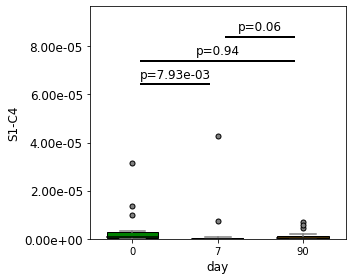

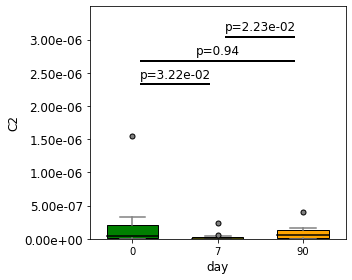

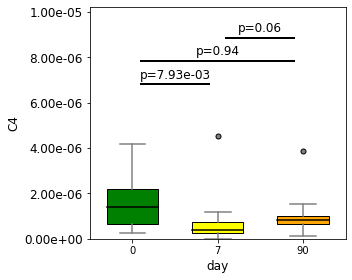

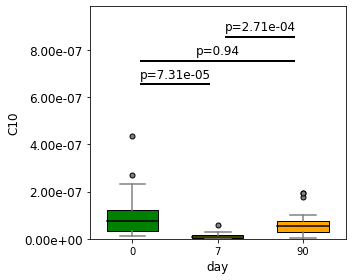

In [12]:
for cluster in e_day_df.index:
    fig, ax = plt.subplots(figsize=(5, 4))
    df = pd.DataFrame(columns=days, index=samples)
    for day in days:
        tmp = exposed_ev_dict[day] 
        df.loc[samples, day] = tmp.loc[samples, cluster]

    bp = ax.boxplot(df[days], labels=days, patch_artist=True, widths=0.6)
    colors = ['green', 'yellow', 'orange']
    max_y = df.max().max()*1.5
    for box, color in zip(bp['boxes'], colors):
        box.set(facecolor=color, alpha=1)

    for whisker in bp['whiskers']:
        whisker.set(color='gray', linewidth=1.5)
    for cap in bp['caps']:
        cap.set(color='gray', linewidth=1.5)
    for median in bp['medians']:
        median.set(color='black', linewidth=1.5)
    for flier in bp['fliers']:
        flier.set(marker='o', markerfacecolor='gray', markersize=5)


    for i, pair in enumerate(e_day_df.columns):
        day0, day1 = pair.split('-')
        day0 = days.index(int(day0))
        day1 = days.index(int(day1))
        value = e_day_df.loc[cluster, pair]
        current_y = max_y*(1+i*0.15)
        ax.plot([1.1+day0, day1+0.9], [current_y]*2, '-', color='black', linewidth=2)
        if value < 0.05:
            ax.text((2+day0+day1)/2, current_y*1.02, "p={:.2e}".format(value), ha='center', va='bottom', fontsize=12)
        else:
            ax.text((2+day0+day1)/2, current_y*1.02, "p={:.2f}".format(value), ha='center', va='bottom', fontsize=12)

    #ax.set_title('SE comparison in different experiment')
    ax.set_xlabel('day', fontsize=12)
    if '_' in cluster:
        ylabel = '{}'.format(cluster.split('_')[1])
    else:
        ylabel = cluster
    ax.set_ylabel(ylabel, fontsize=12)
    plt.yticks(fontsize=12)
    ax.set_ylim(0, max_y*1.5)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, '{}_boxplot.pdf'.format(cluster)), format='pdf')
    plt.show()


In [94]:
# check all abd diff
diff_abd_dict = {}
for d1 in days:
    if d1 not in diff_abd_dict.keys():
        diff_abd_dict[d1] = {}
    tmp1 = exposed_day_data_dict[d1]
    for d2 in days:
        if d1 >= d2:
            continue
        diff_abd_dict[d1][d2] = pd.DataFrame()
        tmp2 = exposed_day_data_dict[d2]
        for sp in tmp1.columns:
            #if list(tmp1[sp]).count(0) > len(tmp1)*0.8:
            #    continue
            if sp not in tmp2.columns:
                v2 = [0]*len(tmp1)
            v1 = tmp1[sp]
            v2 = tmp2[sp]
            t, p = mannwhitneyu(v1, v2)
            diff_abd_dict[d1][d2].loc[sp, 'p'] = p
        diff_abd_dict[d1][d2]['p_adj'] = fdr(list(diff_abd_dict[d1][d2]['p']), 0.05)[1]


In [107]:
len(set(diff_abd_dict[0][7].index).intersection(node_leaves['root']))

275

In [109]:
len(set(diff_abd_dict[0][7].index).intersection(node_leaves['cluster_S1-C4']))

39

In [104]:
for cluster in e_day_df.index:
    leaves = node_leaves[cluster]
    for d1 in days:
        for d2 in days:
            if d1 >= d2:
                continue
            total_tmp = 0
            sig_tmp = 0
            print(len(leaves))
            for sp in leaves:
                if sp not in diff_abd_dict[d1][d2].index:
                    continue
                p = diff_abd_dict[d1][d2].loc[sp, 'p_adj']
                total_tmp += 1
                if p < 0.05:
                    sig_tmp += 1
            print(cluster, d1, d2, sig_tmp, total_tmp, sig_tmp/total_tmp)

46
cluster_S1-C4 0 7 5 39 0.1282051282051282
46
cluster_S1-C4 0 90 0 39 0.0
46
cluster_S1-C4 7 90 2 39 0.05128205128205128
23
cluster_C2 0 7 0 5 0.0
23
cluster_C2 0 90 0 5 0.0
23
cluster_C2 7 90 0 5 0.0
12
cluster_C4 0 7 4 11 0.36363636363636365
12
cluster_C4 0 90 0 11 0.0
12
cluster_C4 7 90 3 11 0.2727272727272727
3
cluster_C10 0 7 2 2 1.0
3
cluster_C10 0 90 0 2 0.0
3
cluster_C10 7 90 2 2 1.0


In [98]:
for cluster in ['root', 'supercluster_S1', 'cluster_S1-C2', 'cluster_S1-C1']:
    leaves = node_leaves[cluster]
    for d1 in days:
        for d2 in days:
            if d1 >= d2:
                continue
            total_tmp = 0
            sig_tmp = 0
            for sp in leaves:
                if sp not in diff_abd_dict[d1][d2].index:
                    continue
                p = diff_abd_dict[d1][d2].loc[sp, 'p_adj']
                total_tmp += 1
                if p < 0.05:
                    sig_tmp += 1
            print(cluster, d1, d2, sig_tmp, total_tmp, sig_tmp/total_tmp)

root 0 7 29 275 0.10545454545454545
root 0 90 0 275 0.0
root 7 90 17 275 0.06181818181818182
supercluster_S1 0 7 22 234 0.09401709401709402
supercluster_S1 0 90 0 234 0.0
supercluster_S1 7 90 12 234 0.05128205128205128
cluster_S1-C2 0 7 14 85 0.16470588235294117
cluster_S1-C2 0 90 0 85 0.0
cluster_S1-C2 7 90 8 85 0.09411764705882353
cluster_S1-C1 0 7 1 35 0.02857142857142857
cluster_S1-C1 0 90 0 35 0.0
cluster_S1-C1 7 90 0 35 0.0


In [101]:
# make heatmap for ev day
# exposed
mean_df = pd.DataFrame(index=node_leaves.keys(), columns=days)
median_df = pd.DataFrame(index=node_leaves.keys(), columns=days)
for day in days:
    tmp = exposed_ev_dict[day]
    mean_df.loc[tmp.columns, day] = tmp.mean()
    median_df.loc[tmp.columns, day] = tmp.median()

mean_df = mean_df.astype(float)
median_df = median_df.astype(float)
# delete all zero rows
mean_df = mean_df.loc[(mean_df!=0).any(axis=1), :]
median_df = median_df.loc[(median_df!=0).any(axis=1), :]

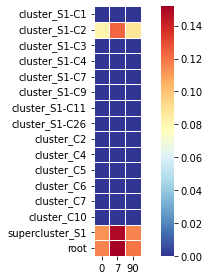

In [102]:
sns.heatmap(mean_df, cmap='RdYlBu_r', square=True, linewidths=0.5, linecolor='white')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'exposed_TI_mean_heatmap.pdf'), format='pdf')
plt.show()

<AxesSubplot: >

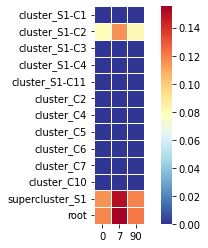

In [103]:
sns.heatmap(median_df, cmap='RdYlBu_r', square=True, linewidths=0.5, linecolor='white')
